
### Algorithm for the ODE system of Von Mises plasticity with combined isotropic/kinematic hardening.


1- define the model parameters, including:

- elastic modulus ($E$),
- initial yield stress ($\sigma_y=E\varepsilon_y$),
- initial kinematic hardening modulus ($C$),
- rate parameter for kinematic hardening modulus ($\gamma$),
- saturation value for isotropic hardening ($Q$),
- rate parameter for isotropic hardening ($b$)

2- define the state variables, including:
- stress ($\sigma$),
- plastic strain ($\varepsilon_{pl}$),
- plastic multiplier ($d\lambda$),
- backstress ($\chi$),
- isotropic hardening variable ($R$)

3- define the yield criteria:

$\Phi=|\sigma - \chi| - (\sigma_y + R)$ 

4- formulate the ODE system in the state-space:

 if $\Phi\leq 0$:

  $d\sigma=E d\varepsilon$

 if $\Phi > 0$:

$$ dX = \begin{bmatrix}
    d\sigma  \\
    d\varepsilon_{pl} \\
    d\lambda \\
    d\chi \\
    dR
    \end{bmatrix} =
    \begin{bmatrix}
    d\varepsilon - d\varepsilon_{pl}  \\
    d\lambda\text{sign}(\sigma-\chi) \\
    \Phi/ (E+C+b) \\
    Cd\varepsilon_{pl}-\gamma\chi d\lambda \\
    b(Q-R)d\lambda
    \end{bmatrix} $$
            
5- solve the ODE system of equations with an ODE solver


Note that some of the states, i.e., plastic strain and plastic multiplier, might be redundant during the solution step. However, they are presented for the sake of completeness and consistency with the conventional plasticity theories.

$$ dX = \begin{bmatrix}
    d\sigma  \\
    d\chi \\
    dR
    \end{bmatrix} =
    \begin{bmatrix}
    d\varepsilon - \frac{[|\sigma - \chi| - (\sigma_y + R)] \text{sign}(\sigma-\chi)}{E+C+b}  \\
    C \frac{[|\sigma - \chi| - (\sigma_y + R)] \text{sign}(\sigma-\chi)}{E+C+b} -\gamma \chi \frac{[|\sigma - \chi| - (\sigma_y + R)]}{E+C+b} \\
    b(Q-R) \frac{[|\sigma - \chi| - (\sigma_y + R)]}{E+C+b}
    \end{bmatrix} $$

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchdyn.numerics import odeint, Euler, HyperEuler
from scipy.interpolate import CubicHermiteSpline
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# from ipywidgets import interact
# %matplotlib qt
# import pyqtgraph as pg
# from pyqtgraph.Qt import QtGui
# plt.rcdefaults()

# figure styling
font=18
font_axis=20
plt.rcParams.update({'font.size': font})  # Set the desired font size
# plt.rcParams['text.usetex'] = True
# plt.rcParams['figure.facecolor'] = 'white'  # Background color for figures
# plt.rcParams['axes.facecolor'] = 'white'    # Background color for axes
# Set the font to Times New Roman globally
plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["mathtext.fontset"] = "stix"  # Use a math font for mathtext (like Greek symbols)

import multiprocessing as mp
import sys
import os
# quick run for automated notebook validation
# dry_run = False

In [2]:
# Different loading path generation strategies 
def deformation(M, tmax, Fmax, Fscale, steps):

    t_interp = np.linspace(0, tmax, steps)
    seed=None

    if seed is not None:
        np.random.seed(seed)
        
    # Divide time interval [0, 1] into M intervals
    t = np.sort(np.random.uniform(0, 1, M))
    t = np.insert(t, 0, 0)  # Ensure t^0 = 0
    t = np.append(t, 1)      # Ensure t^M = 1

    # Initialize F_ij arrays (for i,j=1:3)
    F = np.zeros((M + 2))

    # Initialize velocity increments
    v = np.random.choice([-1, 1], size=(M + 1))  # v_ij are Rademacher variables


    for m in range(1, M + 2):
        delta_t = np.sqrt(t[m] - t[m - 1])
        F[m] = F[ m - 1] + v[m - 1] * Fmax * delta_t

    # Create interpolated paths for F_ij(t)
    interpolated_F = {}


    # Cubic Hermite spline interpolation
    spline = CubicHermiteSpline(t, F, np.gradient(F, t))
    interpolated_F = spline
    derivative_F = spline.derivative(nu=1)
    
    # Interpolate the values
    F_interp = interpolated_F(t_interp)
    F_prim = derivative_F(t_interp)

    max_value =np.max(np.abs(F_interp))
    F_interp = F_interp / max_value
    F_interp = F_interp * Fscale

    F_prim = F_prim / max_value
    F_prim = F_prim * Fscale

    return t_interp, F_interp, F_prim, t, (F / max_value) * Fscale

# Generate custom cyclic strain path (from user-provided function)
def generate_cyclic_strain(max_strain, num_cycles, points_per_cycle=100):
    """
    Generate cyclic strain history.
    """
    lcnd=np.tile([-max_strain,max_strain],num_cycles)
    lcnd=np.insert(lcnd,0,0)
    lcnd=np.insert(lcnd,1,max_strain)

    # Create arrays for strain points
    strain_history = []
    for i in range(len(lcnd)-1):
        if i==0:
            segment = np.linspace(lcnd[i], lcnd[i+1], np.int8(points_per_cycle/2))
        else:
            segment = np.linspace(lcnd[i], lcnd[i+1], points_per_cycle)
        strain_history.extend(segment[:-1])  # Exclude last point to avoid duplicates
    strain_history.append(lcnd[-1])  # Add final point
    steps = np.linspace(0, len(strain_history), len(strain_history))

    return steps, strain_history


def generate_positive_strain_path_with_trend(initial_strain, strain_increment, linear_slope, num_cycles, points_per_segment=100):
    strain = []
    
    # First segment: 0 to initial_strain
    first_segment = np.linspace(0, initial_strain, points_per_segment)[:-1]
    strain.extend(first_segment)
    
    for cycle in range(num_cycles):
        current_max = initial_strain + cycle * strain_increment
        
        # Down to zero
        down_segment = np.linspace(current_max, 0, points_per_segment)[:-1]
        strain.extend(down_segment)
        
        # Up to next max
        next_max = initial_strain + (cycle + 1) * strain_increment
        up_segment = np.linspace(0, next_max, points_per_segment)[:-1]
        strain.extend(up_segment)
    
    # Add final point
    strain.append(initial_strain + (num_cycles - 1) * strain_increment)
    
    # Add linear trend
    strain = np.array(strain)
    time = np.arange(len(strain))
    trend = linear_slope * time
    strain_with_trend = strain + trend
    steps = np.linspace(0, len(strain_with_trend), len(strain_with_trend))

    return steps, strain_with_trend

In [7]:
# Main code to calculate the state of materials under defomation loading (deformation control)

def system_of_odes(state, strain, d_strain):
    """
    System of ODEs for combined isotropic-kinematic hardening plasticity with saturations.

    Parameters:
    - t: Time
    - state: [sigma, alpha, R] (stress, backstress, isotropic hardening variable)
    - strain: Current strain at time t
    - d_strain: Current strain rate at time t
    """
    sigma, alpha, R, lambda_pl, strain_pl = state

    f_yield = abs(sigma - alpha) - (sigma_y + R)
    
    if f_yield < 0 or f_yield == 0:  # Elastic step
        # Stress evolves elastically
        d_sigma = E * d_strain
        d_alpha = 0
        d_R = 0
        d_lambda = 0
        d_strain_pl = 0
        return [d_sigma, d_alpha, d_R, d_lambda, d_strain_pl]
    elif f_yield > 0 :
        # Plastic step
        n = np.sign(sigma - alpha)
        H = E + c + b

        d_lambda = f_yield / H
        d_strain_pl = d_lambda * n

        # Stress evolution
        d_sigma = E * (d_strain - d_strain_pl)
        # Backstress evolution (includes decay term)
        d_alpha = c * d_strain_pl - gamma * alpha * d_lambda
        # Isotropic hardening evolution
        d_R = b * (Q - R) * d_lambda

        return [d_sigma, d_alpha, d_R, d_lambda, d_strain_pl]
    
# Material properties
E = 200e3  # Elastic modulus (MPa)
sigma_y = 150  # Initial yield stress (MPa)
c = 120000    # Kinematic hardening parameter
gamma = 1000  # Backstress saturation parameter
Q = 150  # Saturation value for isotropic hardening (MPa)
b = 5  # Rate of isotropic hardening

# Strain path generation parameters
initial_strain = 0.01   # Maximum strain amplitude
strain_increment = 0
linear_slope = 0
num_cycles = 20         # Number of cycles
points_per_cycle = 200  # Points per cycle

M = 12
Fmax = 1.0
Fscale=0.02
tmax=1
steps=200
# Generate strain and strain rate history (activate one the below 1- cyclic, 2- augmented cyclic, 3- randomised):
steps, strain_history = generate_cyclic_strain(initial_strain, num_cycles, points_per_cycle)
# steps, strain_history = generate_positive_strain_path_with_trend(initial_strain, strain_increment, linear_slope, num_cycles, points_per_cycle)
# steps, strain_history, dstrain, t_point, strain_point = deformation(M, tmax, Fmax, Fscale, steps)

strain_rate = np.diff(strain_history)  # Difference between consecutive elements
strain_rate = np.insert(strain_rate, 0, 0)

# Initial state variables
state = [0, 0, 0, 0, 0]  # Initial conditions: [sigma, alpha, R, lambda, strain_pl]
sigma_history = []
alpha_history = []
R_history = []
Lambda_history = []
strain_pl_history = []

# Solve for each strain step
for i, s in enumerate(steps):
    strain = strain_history[i]
    strain_rate_t = strain_rate[i]
    sol = solve_ivp(
        lambda t, y: system_of_odes(y, strain, strain_rate_t),
        [0, 1],
        state,
        method='RK45'
    )
    state = sol.y[:, -1]
    sigma_history.append(state[0])
    alpha_history.append(state[1])
    R_history.append(state[2])
    Lambda_history.append(state[3])
    strain_pl_history.append(state[4])

# Convert results to arrays
sigma_history = np.array(sigma_history)
alpha_history = np.array(alpha_history)
R_history = np.array(R_history)
Lambda_history = np.array(Lambda_history)
strain_pl_history = np.array(strain_pl_history)


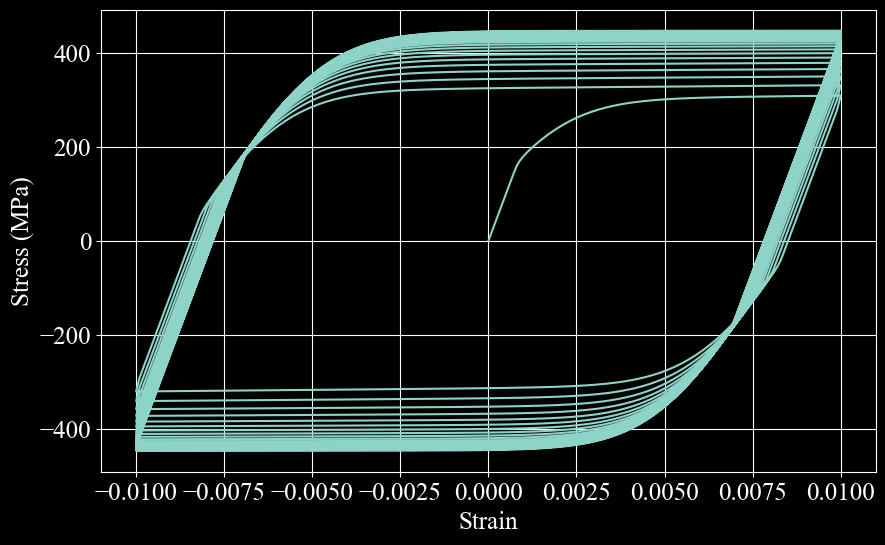

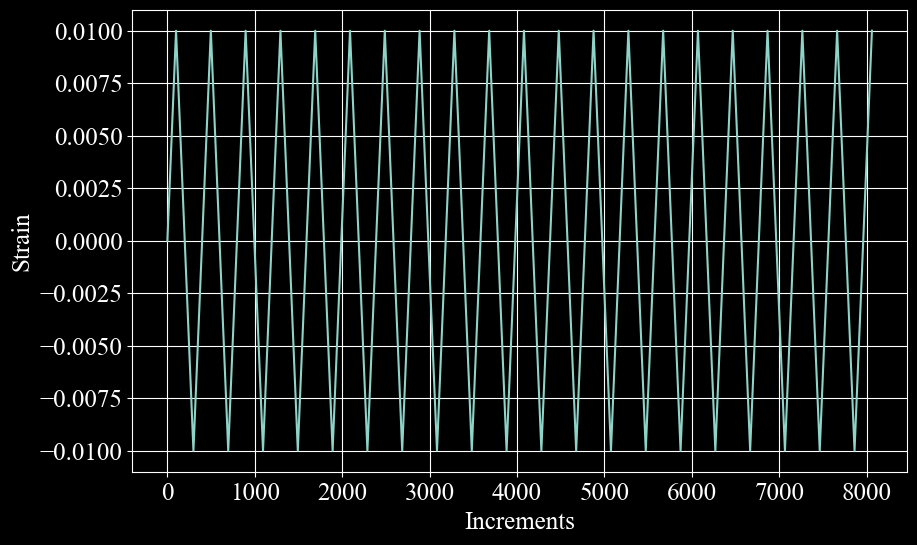

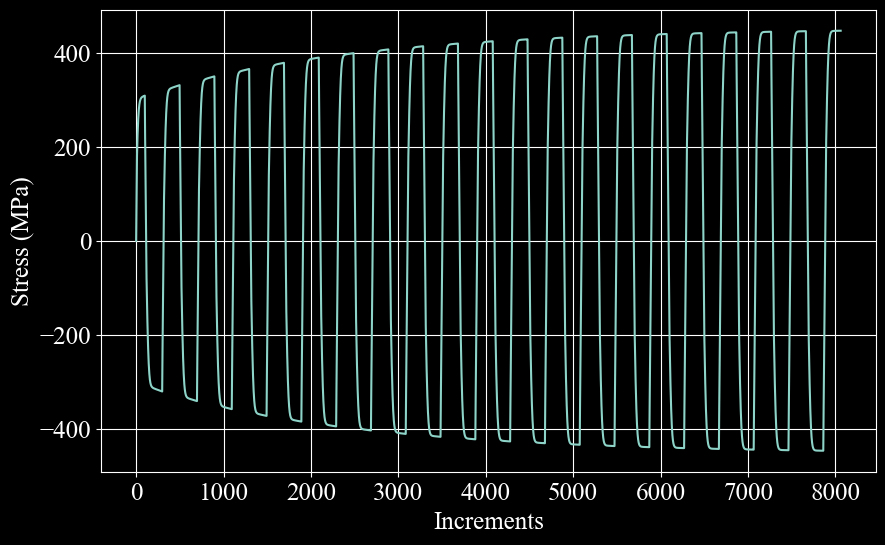

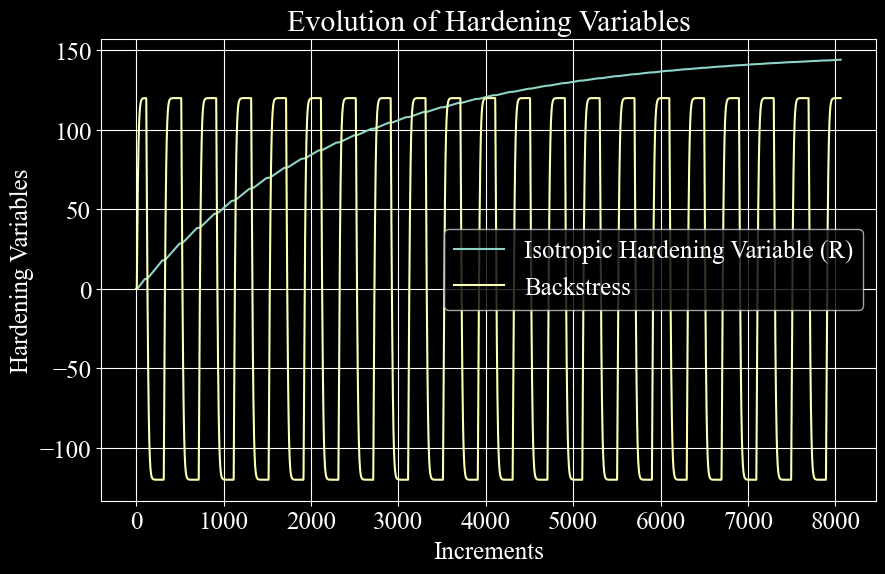

In [8]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(strain_history, sigma_history)
plt.xlabel("Strain")
plt.ylabel("Stress (MPa)")
plt.grid(True)
# plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(steps, strain_history)
plt.xlabel("Increments")
plt.ylabel("Strain")
plt.grid(True)
# plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(steps, sigma_history)
plt.xlabel("Increments")
plt.ylabel("Stress (MPa)")
plt.grid(True)
# plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(steps, R_history, label="Isotropic Hardening Variable (R)")
plt.plot(steps, alpha_history, label="Backstress")
plt.xlabel("Increments")
plt.ylabel("Hardening Variables")
plt.title("Evolution of Hardening Variables")
plt.grid(True)
plt.legend()
plt.show()